In [22]:
# %%
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN # Changed from KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors # Added for eps estimation

# 1 · Load cleaned data
product_df = pd.read_csv("../data/amazon-cleaned.csv")







In [23]:
# 2 · Select numeric features (extend as needed)
num_cols = ["actual_price", "discounted_price", "rating", "encode_review_raing"]
X_train = product_df[num_cols].copy()

X_train.dropna(inplace=True)


# %%
print(f"Shape before dropping duplicates: {X_train.shape}")
print(f"Number of duplicate rows: {X_train.duplicated().sum()}")
X_train.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {X_train.shape}")

# %%


Shape before dropping duplicates: (11446, 4)
Number of duplicate rows: 10190
Shape after dropping duplicates: (1256, 4)


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Shape after PCA: {X_train_pca.shape}")

# %% [markdown]

Shape after PCA: (1256, 4)


Heuristic for min_samples: 8


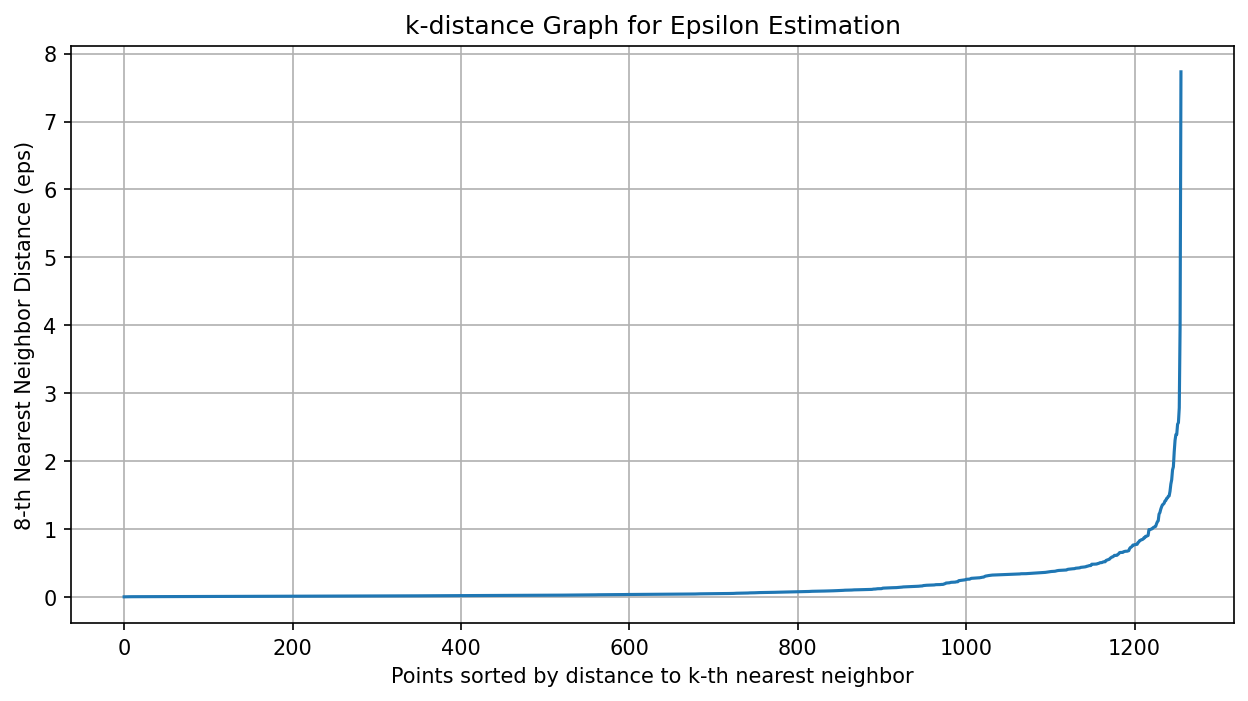

Chosen eps: 1.8
Chosen min_samples: 8


In [25]:

n_dims_for_min_samples = X_train_pca.shape[1]

min_samples_heuristic = 2 * n_dims_for_min_samples
print(f"Heuristic for min_samples: {min_samples_heuristic}")

k_for_nearest_neighbors = min_samples_heuristic
neigh = NearestNeighbors(n_neighbors=k_for_nearest_neighbors)
nbrs = neigh.fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)

# Sort distances to the k-th neighbor
sorted_distances = np.sort(distances[:, k_for_nearest_neighbors-1], axis=0)

plt.figure(figsize=(10, 5), dpi=150)
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{k_for_nearest_neighbors}-th Nearest Neighbor Distance (eps)")
plt.title("k-distance Graph for Epsilon Estimation")
plt.grid(True)
plt.savefig("k_distance_graph.png", dpi=150)
plt.show()

chosen_eps = 1.8
chosen_min_samples = min_samples_heuristic

print(f"Chosen eps: {chosen_eps}")
print(f"Chosen min_samples: {chosen_min_samples}")

# %% [markdown]



In [26]:
# ## 5 · Fit DBSCAN

# %%
dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)
y_labels_dbscan = dbscan.fit_predict(X_train_pca)

n_clusters_ = len(set(y_labels_dbscan)) - (1 if -1 in y_labels_dbscan else 0)
n_noise_ = list(y_labels_dbscan).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# %% [markdown]


Estimated number of clusters: 2
Estimated number of noise points: 4


In [27]:
if n_clusters_ > 1 and len(np.unique(y_labels_dbscan[y_labels_dbscan != -1])) > 1 :
    X_eval = X_train_pca
    labels_eval = y_labels_dbscan

    if X_eval.shape[0] > 1:
        sample_size_dbscan = min(1256, X_eval.shape[0])
        if X_eval.shape[0] > sample_size_dbscan and sample_size_dbscan > 1:
            idx_dbscan = np.random.choice(X_eval.shape[0], sample_size_dbscan, replace=False)
            sil_dbscan = silhouette_score(X_eval[idx_dbscan], labels_eval[idx_dbscan])
        elif X_eval.shape[0] > 1 and len(np.unique(labels_eval)) > 1:
            sil_dbscan = silhouette_score(X_eval, labels_eval)
        else:
            sil_dbscan = -1 
        print(f"Silhouette Score (DBSCAN): {sil_dbscan:.3f}")
    else:
        print("Not enough samples to calculate Silhouette Score for DBSCAN.")


    # Davies-Bouldin Score
    if len(np.unique(labels_eval)) > 1:
        davies_bouldin_dbscan = davies_bouldin_score(X_eval, labels_eval)
        print(f"Davies-Bouldin Index (DBSCAN): {davies_bouldin_dbscan:.3f}")
    else:
        print("Not enough clusters to calculate Davies-Bouldin Index for DBSCAN.")

    # Calinski-Harabasz Score
    if len(np.unique(labels_eval)) > 1:
        calin_dbscan = calinski_harabasz_score(X_eval, labels_eval)
        print(f"Calinski-Harabasz Index (DBSCAN): {calin_dbscan:.3f}")
    else:
        print("Not enough clusters to calculate Calinski-Harabasz Index for DBSCAN.")

else:
    print("DBSCAN resulted in no clusters or only one cluster (excluding noise). Evaluation metrics are not meaningful.")


# %% [markdown]

Silhouette Score (DBSCAN): 0.600
Davies-Bouldin Index (DBSCAN): 0.940
Calinski-Harabasz Index (DBSCAN): 499.933


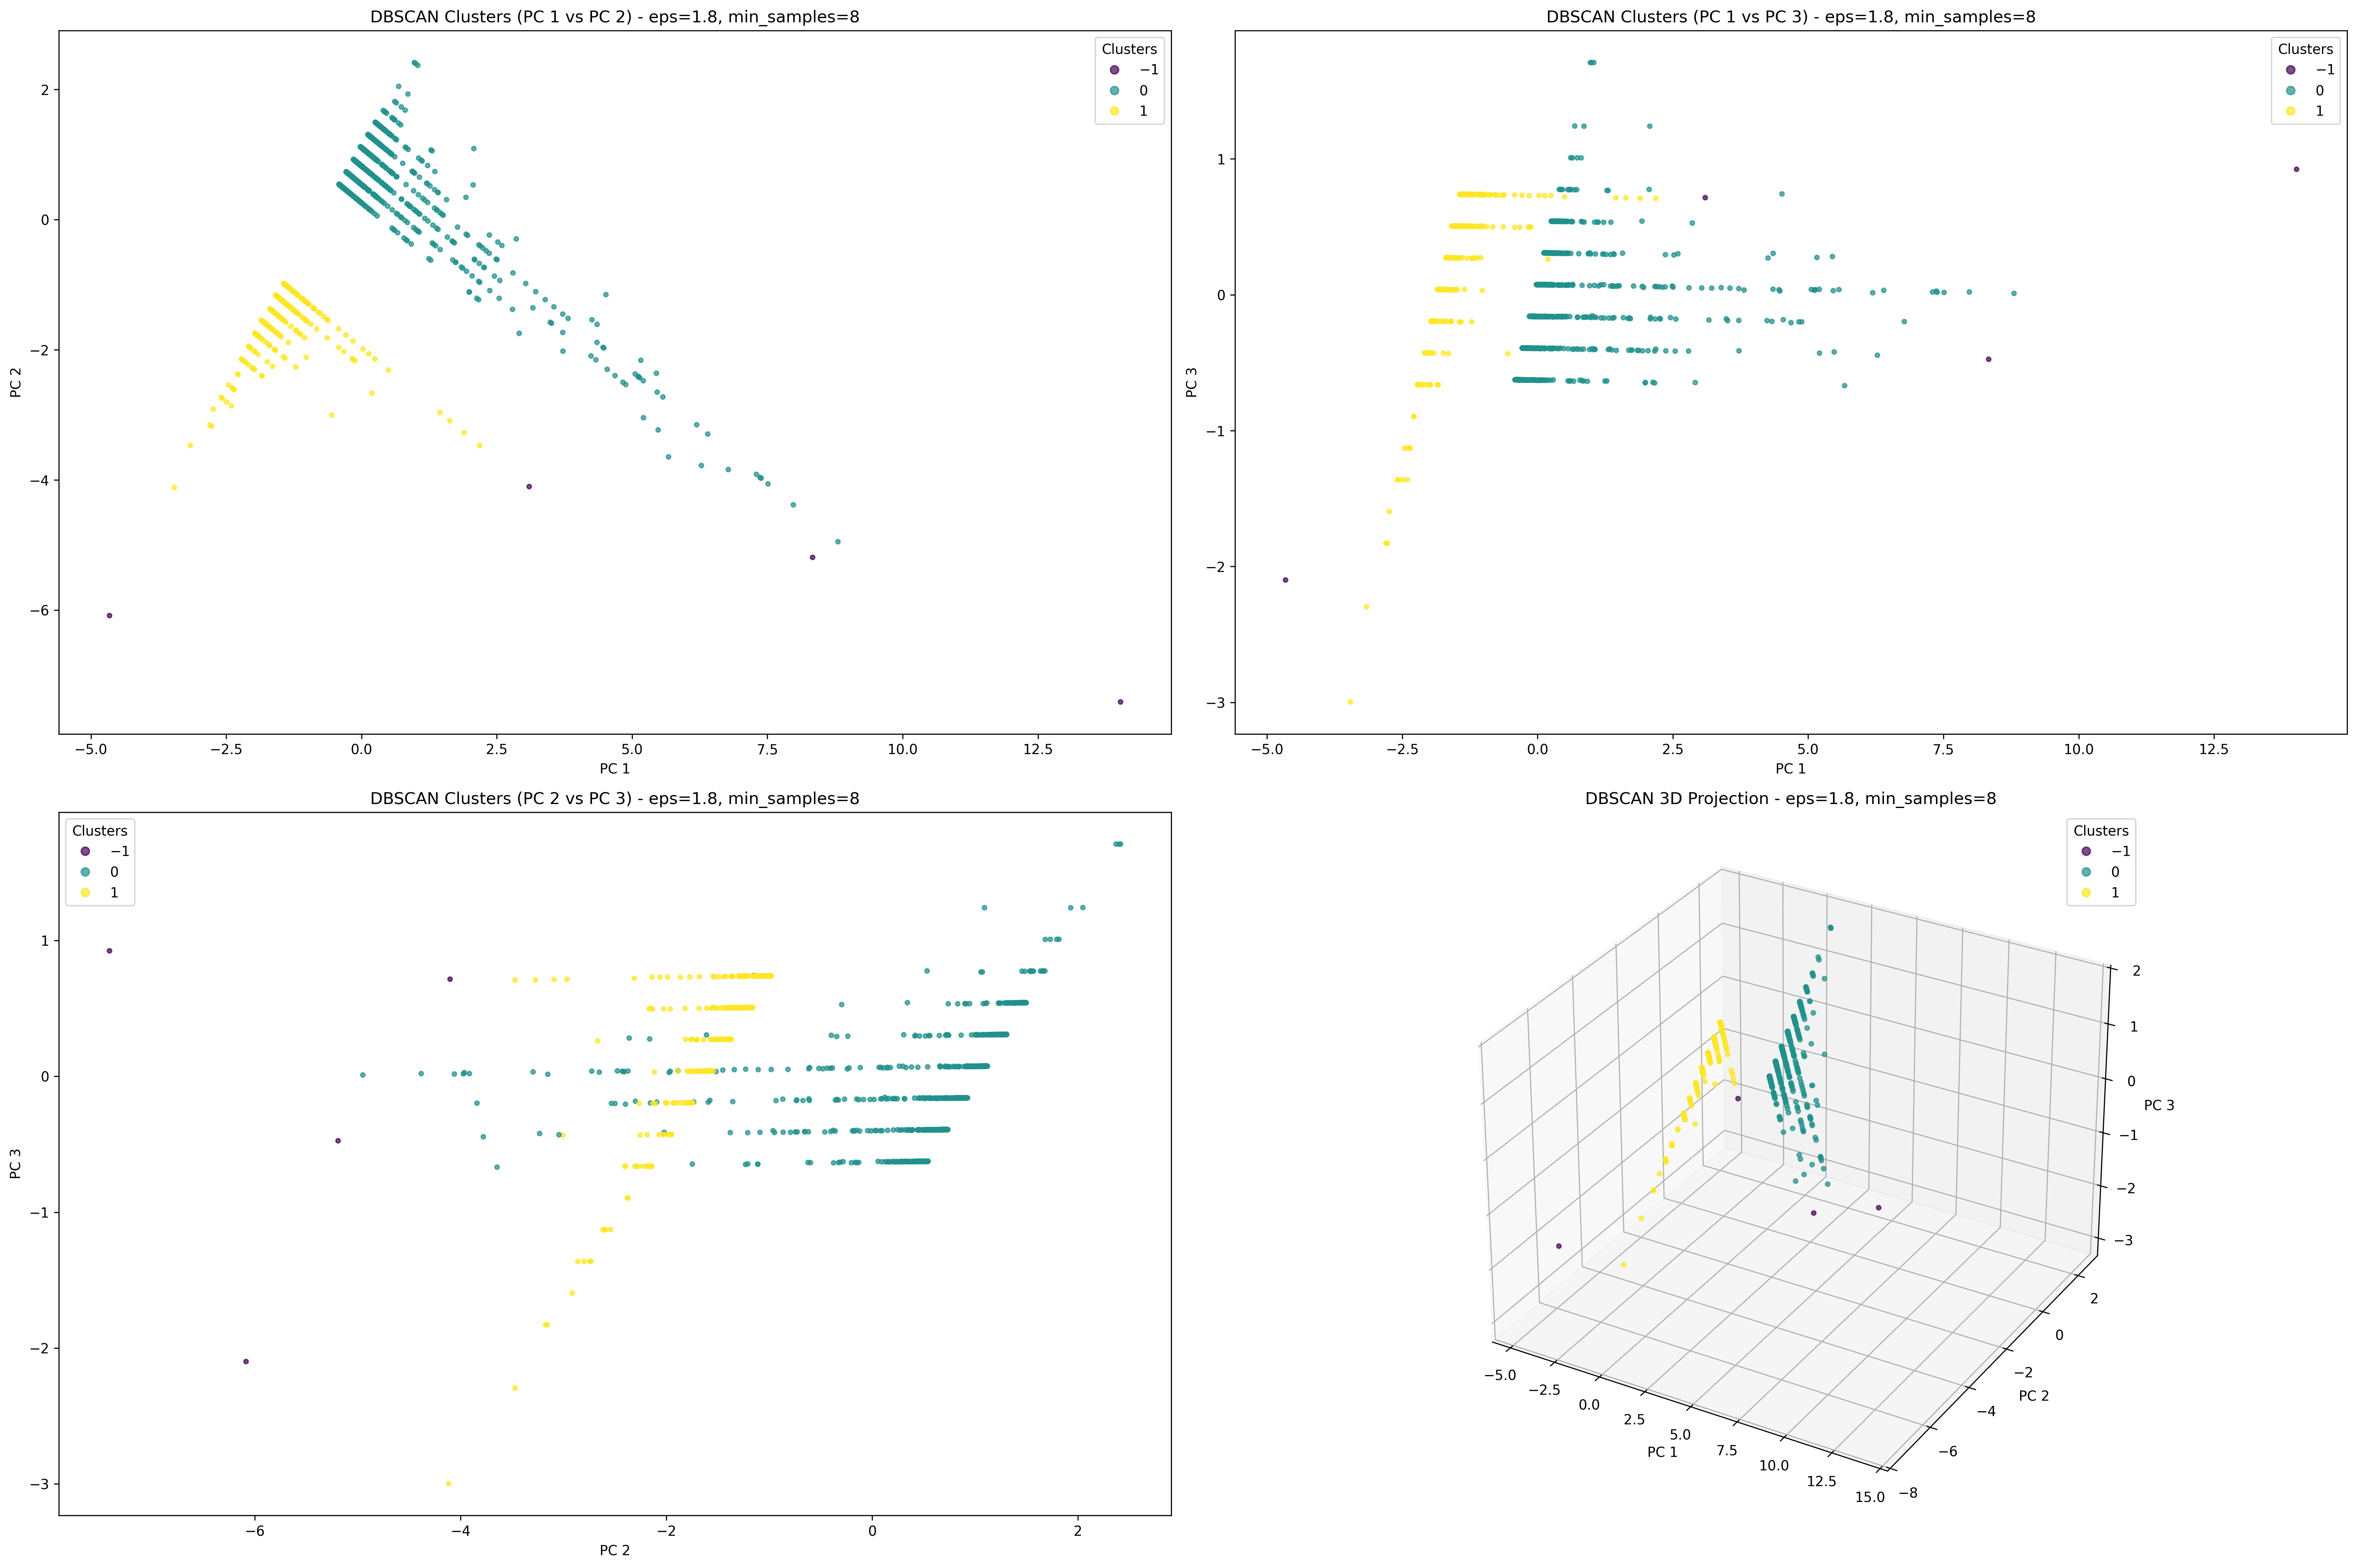


DBSCAN clustering performed on X_train_pca with eps=1.8 and min_samples=8.
Number of data points in each cluster:
dbscan_cluster
-1      4
 0    925
 1    327
Name: count, dtype: int64


In [28]:

plot_labels_dbscan = y_labels_dbscan

plt.figure(figsize=(24,16), dpi = 300)

# PC1 vs PC2
plt.subplot(2,2,1)
scatter1_db = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=plot_labels_dbscan, cmap='viridis', s=10, alpha=0.7)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(f'DBSCAN Clusters (PC 1 vs PC 2) - eps={chosen_eps}, min_samples={chosen_min_samples}')
if n_clusters_ > 0 :
    plt.legend(*scatter1_db.legend_elements(), title="Clusters")


# PC1 vs PC3
plt.subplot(2,2,2)
scatter2_db = plt.scatter(X_train_pca[:,0], X_train_pca[:,2], c=plot_labels_dbscan, cmap='viridis', s=10, alpha=0.7)
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title(f'DBSCAN Clusters (PC 1 vs PC 3) - eps={chosen_eps}, min_samples={chosen_min_samples}')
if n_clusters_ > 0:
    plt.legend(*scatter2_db.legend_elements(), title="Clusters")

# PC2 vs PC3
plt.subplot(2,2,3)
scatter3_db = plt.scatter(X_train_pca[:,1], X_train_pca[:,2], c=plot_labels_dbscan, cmap='viridis', s=10, alpha=0.7)
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title(f'DBSCAN Clusters (PC 2 vs PC 3) - eps={chosen_eps}, min_samples={chosen_min_samples}')
if n_clusters_ > 0:
    plt.legend(*scatter3_db.legend_elements(), title="Clusters")

# 3D Projection
ax = plt.subplot(2, 2, 4, projection='3d')
scatter4_db = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=plot_labels_dbscan, cmap='viridis', s=10, alpha=0.7)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title(f'DBSCAN 3D Projection - eps={chosen_eps}, min_samples={chosen_min_samples}')
if n_clusters_ > 0:
    ax.legend(*scatter4_db.legend_elements(), title="Clusters")


plt.tight_layout()
plt.savefig("dbscan_clusters.png", dpi=300)
plt.show()

# Assign DBSCAN cluster labels to the original data
X_train_with_clusters_dbscan = X_train.copy()
X_train_with_clusters_dbscan['dbscan_cluster'] = y_labels_dbscan

print(f"\nDBSCAN clustering performed on X_train_pca with eps={chosen_eps} and min_samples={chosen_min_samples}.")
print(f"Number of data points in each cluster:\n{X_train_with_clusters_dbscan['dbscan_cluster'].value_counts().sort_index()}")

In [29]:
# --- DBSCAN Cluster Mean Table ---
cluster_means_dbscan = X_train_with_clusters_dbscan.groupby('dbscan_cluster')[num_cols].mean()
print("\nMean values for each cluster (DBSCAN):")
print(cluster_means_dbscan)


Mean values for each cluster (DBSCAN):
                actual_price  discounted_price    rating  encode_review_raing
dbscan_cluster                                                               
-1              65598.500000      41446.750000  3.675000                 1.25
 0               6105.236757       3580.679957  4.227676                 2.00
 1               3150.503425       1660.404312  3.704281                 1.00


In [30]:
# --- Global Mean Table ---
global_means_dbscan = X_train[num_cols].mean()
print("\nGlobal mean values for features:")
print(global_means_dbscan)


Global mean values for features:
actual_price           5525.439984
discounted_price       3201.328161
rating                    4.089650
encode_review_raing       1.737261
dtype: float64
